In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from libertem import api

In [4]:
ctx = api.Context()

In [5]:
ds = ctx.load(
    "raw",
    path="C:/Users/weber/ownCloud/Projects/Open Pixelated STEM framework/Data/EMPAD/scan_11_x256_y256.raw",
    dtype="float32",
    scan_size=(256, 256),
    detector_size_raw=(130, 128),
    crop_detector_to=(128, 128),
)
(scan_y, scan_x, detector_y, detector_x) = ds.shape
mask_shape = np.array((detector_y, detector_x))
cx = detector_x/2
cy = detector_y/2

In [6]:
def all_ones():
    return np.ones((128, 128))

In [7]:
def single_pixel():
    buf = np.zeros((128, 128))
    buf[64, 64] = 1
    return buf

Here we use a mask job. Jobs generally use the LiberTEM computation rather directly and return a simple numerical result. See further below for examples that use the high-level analysis interface instead.

In [8]:
job = ctx.create_mask_job(factories=[all_ones, single_pixel], dataset=ds)

In [9]:
%%time
result = ctx.run(job)

Wall time: 27.6 s


<IPython.core.display.Javascript object>


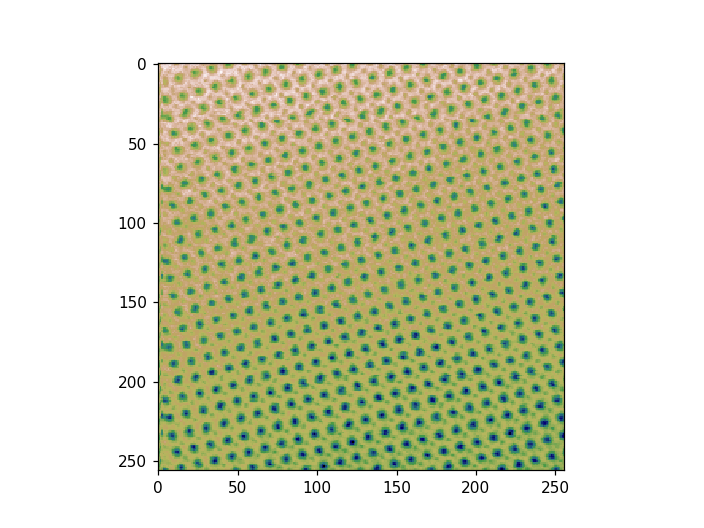

In [10]:
fig, axes = plt.subplots()
axes.imshow(result[0], cmap=cm.gist_earth)

<IPython.core.display.Javascript object>


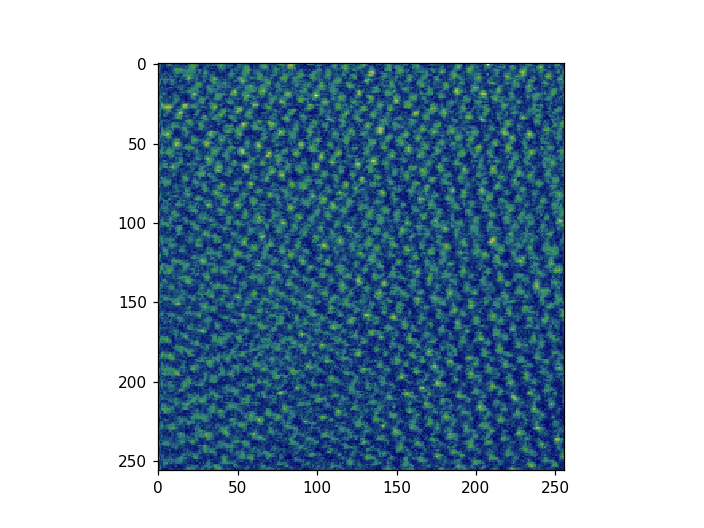

In [11]:
fig, axes = plt.subplots()
axes.imshow(result[1], cmap=cm.gist_earth)

In [12]:
ro = min(detector_x,detector_y)/2
haadf_analysis = ctx.create_ring_analysis(dataset=ds, cx=cx, cy=cy, ro=ro, ri=ro*0.8)

In [13]:
%time haadf_result = ctx.run(haadf_analysis)

Wall time: 23 s


In [14]:
print(haadf_result)

[<AnalysisResult: intensity>]


In [15]:
print(haadf_result.intensity)

title: intensity
desc: intensity of the integration over the selected ring
key: intensity
raw_data: [[1430498.1 1472582.9 1331891.1 ... 1406989.2 1441294.2 1464622.6]
 [1390670.5 1441177.1 1347792.6 ... 1302910.8 1314042.2 1347872.8]
 [1407067.9 1564187.4 1444740.4 ... 1396888.  1321350.9 1317518.8]
 ...
 [1905181.5 1706497.4 1620345.5 ... 1792412.9 1785900.2 1752096.8]
 [1795231.5 1651401.  1675191.6 ... 1867160.6 1833695.5 1820662. ]
 [1758158.  1666727.8 1691829.6 ... 1918685.  1812730.2 1776172.2]]
visualized: [[[ 38 105 125 255]
  [ 43 118 126 255]
  [ 25  69 121 255]
  ...
  [ 35  97 124 255]
  [ 39 109 125 255]
  [ 43 116 126 255]]

 [[ 33  92 123 255]
  [ 39 109 125 255]
  [ 27  75 121 255]
  ...
  [ 21  56 120 255]
  [ 22  60 120 255]
  [ 27  75 121 255]]

 [[ 35  97 124 255]
  [ 54 135 111 255]
  [ 40 110 125 255]
  ...
  [ 33  94 123 255]
  [ 23  64 121 255]
  [ 23  62 120 255]]

 ...

 [[145 172  86 255]
  [ 67 152  76 255]
  [ 59 141  98 255]
  ...
  [102 162  77 255]
  [ 

<IPython.core.display.Javascript object>


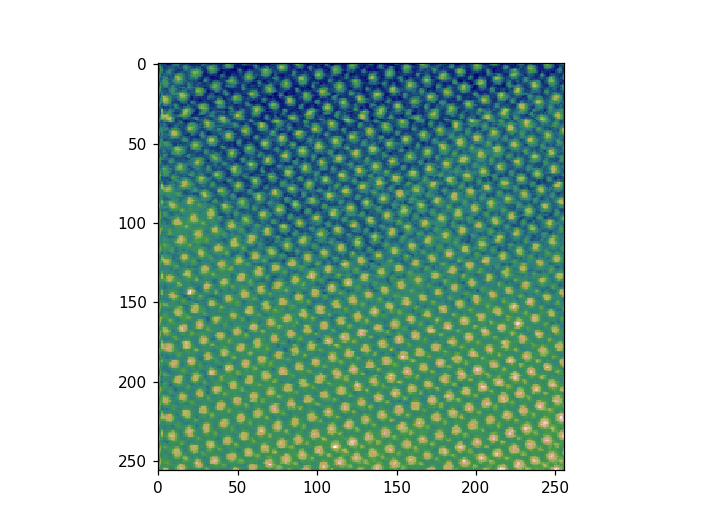

In [16]:
fig, axes = plt.subplots()
axes.imshow(haadf_result.intensity.visualized)